#  Прогнозирование заказов такси

В данном проекте решалась задача прогнозирования временного ряда

Были выявлены зависимости и спрогнозированы заказы такси на основе года, месяца, часа предыдущих периодов

**Импорты библиотек**

In [2]:
RANDOM_STATE = 42

## Выгрузка данных

In [3]:
try:
    data = pd.read_csv('../datasets/taxi.csv1')
except:
    pass

In [4]:
display(data.head())
print('_'* 80)
display(data.info())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

Для начала преобразуем время в формат datetime[ns]

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data = data.resample('1H').sum()

Сразу создадим нужные календарные признаки. В тренажёре можно было передавать year без dt, так как дата была индексом. В этом проекте вопользуемся dt

In [6]:
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

Год не берём. Он везде 2018 и для анализа не пригодится

## Анализ данных

### Динамика признака

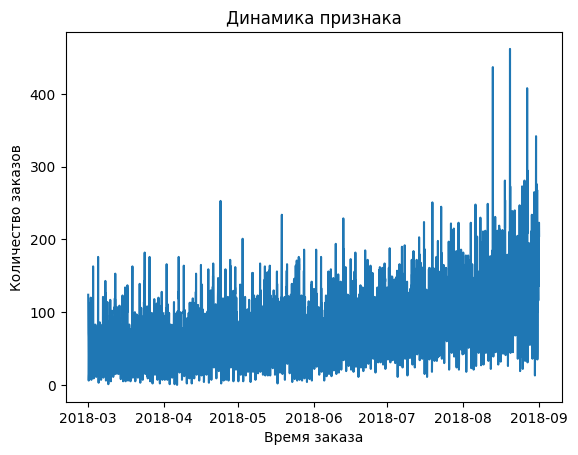

In [7]:
sns.lineplot(data = data, x = data.index, y='num_orders')

plt.title('Динамика признака')
plt.ylabel('Количество заказов')
plt.xlabel('Время заказа')
plt.show()

### Агрегирование, скользящее среднее

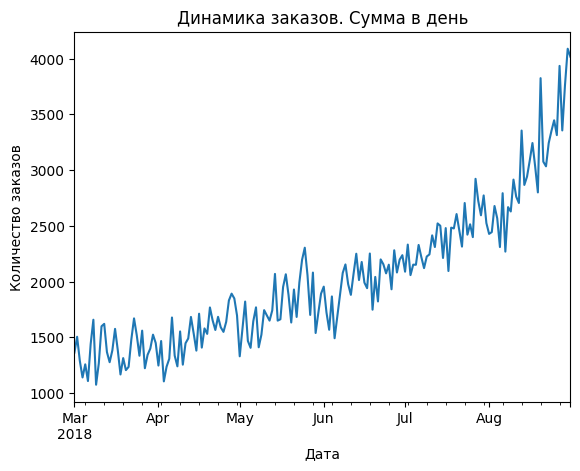

In [8]:
data.resample('1D').sum()['num_orders'].plot()
plt.title('Динамика заказов. Сумма в день')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

В целом в данных явно виден тренд на рост заказов. Попробуем его отразить более плавно используя скользящее среднее

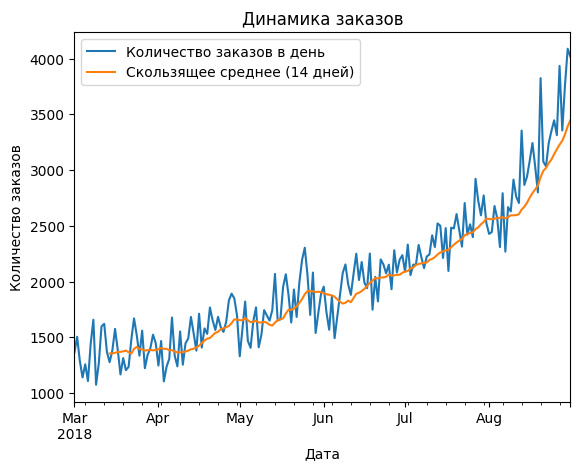

In [9]:
data.resample('1D').sum()['num_orders'].plot()
data.resample('1D').sum().rolling(14).mean()['num_orders'].plot()
plt.title('Динамика заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend(labels = ['Количество заказов в день',
                     'Скользящее среднее (14 дней)'])
plt.show()

### Тренды и сезонность

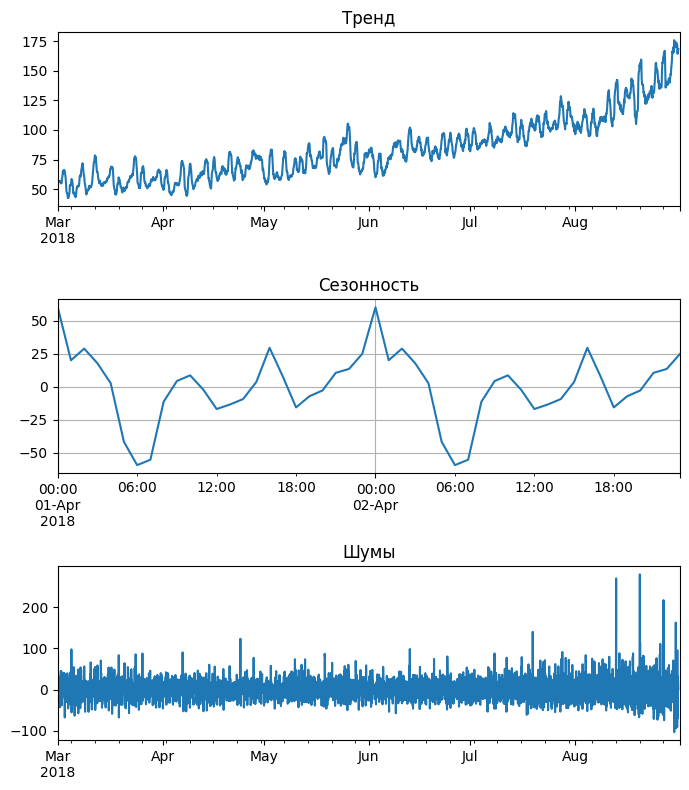

In [10]:
decomposed = seasonal_decompose(data.resample('1H').sum()['num_orders'])
fig, ax = plt.subplots(3,1,figsize = (7,8))

decomposed.trend.plot(ax=ax[0])
ax[0].set_title("Тренд")
ax[0].set_xlabel("")

decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=ax[1])
ax[1].grid()
ax[1].set_title("Сезонность")   
ax[1].set_xlabel("")

# ax[1].set_xticks(decomposed.seasonal['2018-04-01':'2018-04-14'].index)
# labels = decomposed.seasonal['2018-04-01':'2018-04-14'].index.day_name()
# ax[1].set_xticklabels(labels=labels,rotation=45)

decomposed.resid.plot(ax=ax[2])
ax[2].set_title("Шумы")
ax[2].set_xlabel("")

plt.tight_layout()

### Проверка датасета

**Дубликаты**

In [11]:
data.duplicated().sum()

1427

Дубликатов не найдено

**Выбросы**

При построении графиков мы выбросов не увидели, оставляем эти данные без изменений

Мы видим что наименьшее количесто заказов по средам согласно 12 часов вечера. Скорее всего связано с рейсами

- Явно наблюдается снижение заказов в 06:00. Возможно в это время проводят ТО или самолёты не прилетают по каким-то другим причинам

- Тренд восходящий

- Шумы в целом можно назвать стационарным рядом, хотя в августе их амплитуда увеличивается

##  Предобработка

### Добавление новых признаков

Создадим функцию для добавления отстающих значений и скользящего среднего

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    """Функция принимает на вход
    - датасет
    - max_lag - количество отстающих значений
    - rolling_mean_size размер ширины окна скользящего среднего
    """
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    
    return data

Создадим новый датасет оптимальными значениями отстающего значения и скользящего среднего

In [13]:
data_new = make_features(data, 60, 60)

### Создание тестовой выборки

Будем создавать только train, так как для обучения будем пользоваться кросс валидацией

In [14]:
features = data_new.drop(columns = ['num_orders'])
target = data_new['num_orders']

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.1, shuffle = False, random_state=RANDOM_STATE
)

### Нормализация данных

In [16]:
scaler =  MinMaxScaler()
scaler.fit(features_train)

MinMaxScaler()

In [17]:
features_train = pd.DataFrame(data = scaler.transform(features_train),
                              columns = features_train.columns)

features_test = pd.DataFrame(data = scaler.transform(features_test),
                              columns = features_test.columns)

## Обучение модели

### Регрессор дополнительных деревьев

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
model_et = ExtraTreesRegressor(random_state = RANDOM_STATE,
                                    n_jobs = -1 )
# n_jobs = -1  - увеличиваем количество параллельных вычислений

In [20]:
params_et  = {
    'n_estimators' :range(70,100,10),
    'max_depth':range(20,30,1)
}

In [21]:
clf_et = GridSearchCV(model_et,
                   params_et,
                   cv = tscv,
                   verbose=1,
                   scoring = 'neg_mean_squared_error'
              )

In [22]:
clf_et.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': range(20, 30),
                         'n_estimators': range(70, 100, 10)},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
print('Лучшее значение')
(- clf_et.best_score_) ** 0.5

Лучшее значение


24.245455064459655

In [24]:
clf_et.best_params_

{'max_depth': 24, 'n_estimators': 90}

### Случайный лес

In [25]:
model_rf = RandomForestRegressor(random_state = RANDOM_STATE,
                                 n_jobs = -1 )

In [26]:
params_rf  = {
    'n_estimators' :range(80,100,10),
    'max_depth':range(20,30,2)
}

In [27]:
clf_rf = GridSearchCV(model_rf,
                   params_rf,
                   cv = tscv,
                   verbose=1,
                   scoring = 'neg_mean_squared_error'
              )

In [28]:
clf_rf.fit(features_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': range(20, 30, 2),
                         'n_estimators': range(80, 100, 10)},
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
print('Лучшее значение')
(- clf_rf.best_score_) ** 0.5

Лучшее значение


24.932152764451548

In [30]:
clf_rf.best_params_

{'max_depth': 26, 'n_estimators': 90}

### Catboost

In [31]:
model_cat = CatBoostRegressor(iterations =1500,
                              max_depth= 6,
                             l2_leaf_reg = 0.1,
                             loss_function = 'RMSE',
                             learning_rate = 0.1,
                             verbose = 300,
                             random_state = RANDOM_STATE)

In [32]:
clf_cat = GridSearchCV(model_cat,
                   {},
                   cv = tscv,
                   verbose=1,
                   scoring = 'neg_mean_squared_error'
              )

In [33]:
clf_cat.fit(features_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 27.8129752	total: 168ms	remaining: 4m 12s
300:	learn: 1.2925175	total: 2.62s	remaining: 10.4s
600:	learn: 0.1237401	total: 4.76s	remaining: 7.12s
900:	learn: 0.0117508	total: 6.68s	remaining: 4.44s
1200:	learn: 0.0010694	total: 8.65s	remaining: 2.15s
1499:	learn: 0.0000995	total: 10.4s	remaining: 0us
0:	learn: 29.0206261	total: 8.16ms	remaining: 12.2s
300:	learn: 3.9039617	total: 1.96s	remaining: 7.8s
600:	learn: 0.9879895	total: 3.96s	remaining: 5.93s
900:	learn: 0.2597359	total: 5.97s	remaining: 3.97s
1200:	learn: 0.0719986	total: 8.07s	remaining: 2.01s
1499:	learn: 0.0206316	total: 10.3s	remaining: 0us
0:	learn: 30.6064336	total: 7.92ms	remaining: 11.9s
300:	learn: 6.0031431	total: 2.58s	remaining: 10.3s
600:	learn: 2.0775485	total: 6.15s	remaining: 9.21s
900:	learn: 0.7920774	total: 8.77s	remaining: 5.83s
1200:	learn: 0.3129552	total: 11.2s	remaining: 2.78s
1499:	learn: 0.1270157	total: 13.9s	remaining: 0us
0:	lea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000002A1CD2AFAC0>,
             param_grid={}, scoring='neg_mean_squared_error', verbose=1)

In [34]:
(- clf_cat.best_score_) ** 0.5

24.129011510317962

### Линейная модель

In [35]:
model_linean = LinearRegression()

clf_lin = GridSearchCV(model_linean,
                   {},
                   cv = tscv,
                   verbose=1,
                   scoring = 'neg_mean_squared_error'
              )

In [36]:
clf_lin.fit(features_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_mean_squared_error', verbose=1)

In [37]:
(- clf_lin.best_score_) ** 0.5

8039047528054.966

## Тестирование

Итого выбираем catboots, который показал себя лучше, хоть и на намного ансамблевых моделей

In [38]:
mean_squared_error(target_test, 
                   clf_cat.predict(features_test),
                   squared=False)

40.5134167285452

Итого RMSE = 40.51. Нужный результат достигнут

In [39]:
predict = clf_cat.predict(features_test)

<AxesSubplot:xlabel='datetime'>

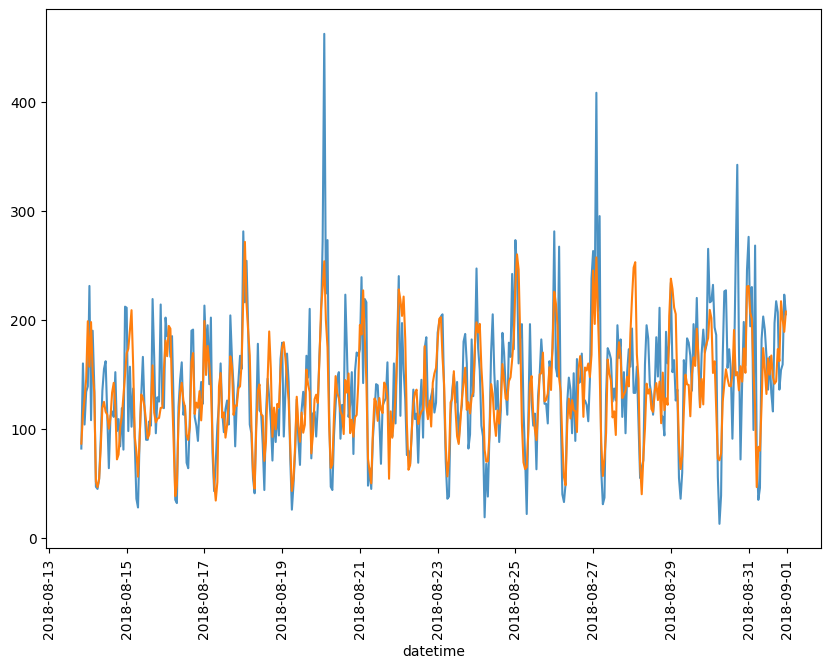

In [40]:
plt.figure(figsize=(10,7))
sns.lineplot(x= target_test.index, y = target_test.values, alpha = 0.8)
plt.xticks(rotation=90)
sns.lineplot(x= target_test.index, y = predict)

## Выводы
- В текущих данных наблюдается рост заказов от месяца к месяцу
- Явно наблюдается снижение заказов в 06:00. Возможно в это время проводят ТО или самолёты не прилетают по каким-то другим причинам
- Тренд восходящий
- Шумы в целом можно назвать стационарным рядом, хотя в августе их амплитуда увеличивается
- Обучение проходило при помощи кросс валидации
- Из моделей лучше себя показал CatBoost